## ACE K-MEANS CLUSTERING EVALUATION

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


In [154]:
def plot_cluster_evaluations(dfs, class_names, enviornment_name):
    agreement_results = []

    for df, class_name in zip(dfs, class_names):
        print(f"\n\n{class_name}, evaluation of k:\n")
        for layer_i in range(6):
            if layer_i == 2:
                continue
            
            print(layer_i)
            filtered = df[df["layer"] == layer_i]

            best_row_cps = filtered.loc[filtered['weighted_average_concept_probe_score'].idxmax()]
            best_k_cps = best_row_cps['k'].item()
            best_cps = best_row_cps['weighted_average_concept_probe_score'].item()

            best_row_ss = filtered.loc[filtered['silhouette_score'].idxmax()]
            best_k_ss = best_row_ss['k'].item()
            best_ss = best_row_ss['silhouette_score'].item()

            k_distance = abs(best_k_cps - best_k_ss)
            agreement_results.append({
                "class_name": class_name,
                "layer": layer_i,
                "best_k_cps": best_k_cps,
                "best_k_ss": best_k_ss,
                "distance": k_distance
            })

            best_k_cps = filtered.loc[filtered['weighted_average_concept_probe_score'].idxmax(), 'k'].item()
            plt.figure(figsize=(8, 6))
            plt.plot(
                filtered["k"],
                filtered["weighted_average_concept_probe_score"],
                color="orange",
                label="Weighted Average CPS",
            )
            plt.plot(
                filtered["k"],
                filtered["silhouette_score"],
                color="blue",
                label="Silhouette Score"
            )
            plt.scatter(best_k_cps, best_cps, color="red", label=f"Best k WACPS = {best_k_cps}", zorder=5)
            plt.scatter(best_k_ss, best_ss, color="green", label=f"Best k SS = {int(best_k_ss)}", zorder=6)

            plt.title(f"Evaluation of k, {enviornment_name}, {class_name}, layer {layer_i}")

            plt.legend()
            plt.xlabel("k")
            plt.ylim(bottom=-0.2, top=1)
            plt.show()

    agreement_df = pd.DataFrame(agreement_results)
    return agreement_df



In [155]:
def compute_stats(gr_agreement_df, dfs, class_names):
    """
    Computes three sets of statistics:
      1. Average distance between best k (CPS vs SS) per layer from gr_agreement_df.
      2. Top weighted average CPS scores per layer (excluding layer 2) from a list of DataFrames.
      3. Average best k per layer (CPS vs SS) from the same list of DataFrames.
      
    Parameters:
        gr_agreement_df (pd.DataFrame): DataFrame containing at least the columns "layer" and "distance".
        dfs (list of pd.DataFrame): List of DataFrames, each with columns "layer",
            "weighted_average_concept_probe_score", "silhouette_score", and "k".
        class_names (list of str): Names corresponding to each DataFrame in dfs.
        
    Returns:
        dict: A dictionary containing the three resulting DataFrames:
            - "layer_avg_distances"
            - "top_scores_df"
            - "avg_k_comparison"
    """
    
    # 1. Compute average distance between best k (CPS vs SS) per layer
    layer_avg_distances = gr_agreement_df.groupby("layer")["distance"].mean().reset_index()
    layer_avg_distances.columns = ["layer", "avg_k_distance"]
    print("\nAverage distance between best k (CPS vs SS) per layer:\n")
    print(layer_avg_distances)
    
    # 2. Compute top weighted average CPS scores per layer (excluding layer 2)
    top_scores_per_layer = {}
    for df, class_name in zip(dfs, class_names):
        layer_scores = []
        for layer_i in range(6):
            if layer_i == 2:
                continue  # Skip layer 2
            filtered = df[df["layer"] == layer_i]
            if filtered.empty:
                layer_scores.append(float('nan'))
            else:
                top_score = filtered["weighted_average_concept_probe_score"].max()
                layer_scores.append(top_score)
        top_scores_per_layer[class_name] = layer_scores

    # Define the layer indices (excluding layer 2)
    layers_excl_2 = [0, 1, 3, 4, 5]
    top_scores_df = pd.DataFrame(top_scores_per_layer, index=layers_excl_2)
    top_scores_df.index.name = "layer"
    print("\nTop weighted average CPS scores per layer:\n")
    print(top_scores_df)
    
    # 3. Compute average best k per layer (CPS vs SS)
    layer_k_cps = defaultdict(list)
    layer_k_ss = defaultdict(list)
    
    for df in dfs:
        for layer_i in range(6):
            if layer_i == 2:
                continue  # Skip layer 2
            filtered = df[df["layer"] == layer_i]
            if filtered.empty:
                continue
            
            # Best k by CPS
            best_row_cps = filtered.loc[filtered['weighted_average_concept_probe_score'].idxmax()]
            best_k_cps = best_row_cps['k'].item() if hasattr(best_row_cps['k'], 'item') else best_row_cps['k']
            layer_k_cps[layer_i].append(best_k_cps)
            
            # Best k by Silhouette Score
            best_row_ss = filtered.loc[filtered['silhouette_score'].idxmax()]
            best_k_ss = best_row_ss['k'].item() if hasattr(best_row_ss['k'], 'item') else best_row_ss['k']
            layer_k_ss[layer_i].append(best_k_ss)
    
    # Combine the best k values into a single DataFrame for comparison
    layers = sorted(set(layer_k_cps.keys()) | set(layer_k_ss.keys()))
    avg_k_comparison = pd.DataFrame({
        "avg_best_k_cps": [sum(layer_k_cps[l]) / len(layer_k_cps[l]) for l in layers],
        "avg_best_k_ss": [sum(layer_k_ss[l]) / len(layer_k_ss[l]) for l in layers],
    }, index=layers)
    avg_k_comparison.index.name = "layer"
    print("\nAverage best k per layer (CPS vs SS):\n")
    print(avg_k_comparison)
    
    # Return all computed statistics in a dictionary for further use if needed
    return {
        "layer_avg_distances": layer_avg_distances,
        "top_scores_df": top_scores_df,
        "avg_k_comparison": avg_k_comparison
    }

### GoldRun

In [156]:
gr_balanced_k_scores = pd.read_csv("../../rl_ace_data/concept_examples/gold_run_mini/k_means/model_of_interest_target_class_balanced_observations/dim_reduction/k_evaluation.csv")
gr_up_k_scores = pd.read_csv("../../rl_ace_data/concept_examples/gold_run_mini/k_means/model_of_interest_target_class_up_observations/dim_reduction/k_evaluation.csv")
gr_right_k_scores = pd.read_csv("../../rl_ace_data/concept_examples/gold_run_mini/k_means/model_of_interest_target_class_right_observations/dim_reduction/k_evaluation.csv")
gr_down_k_scores = pd.read_csv("../../rl_ace_data/concept_examples/gold_run_mini/k_means/model_of_interest_target_class_down_observations/dim_reduction/k_evaluation.csv")
gr_left_k_scores = pd.read_csv("../../rl_ace_data/concept_examples/gold_run_mini/k_means/model_of_interest_target_class_left_observations/dim_reduction/k_evaluation.csv")

gr_dfs = [gr_balanced_k_scores, gr_up_k_scores, gr_right_k_scores, gr_down_k_scores, gr_left_k_scores]
gr_class_names = ["all actions balanced", "action up", "action right", "action down", "action left"]



all actions balanced, evaluation of k:

0


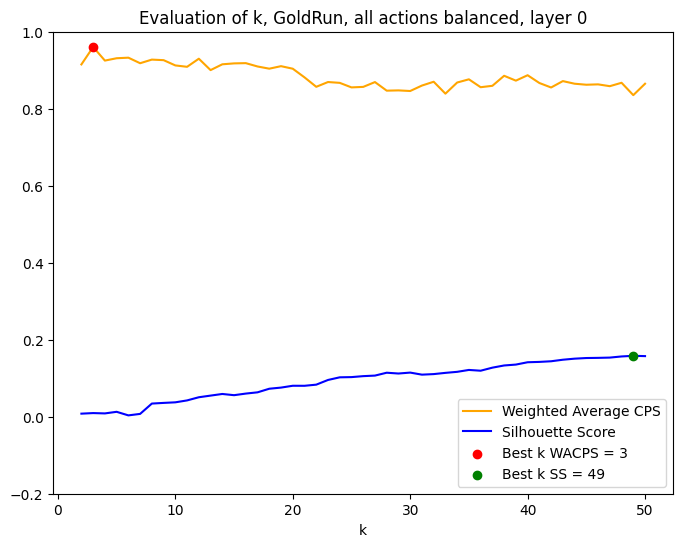

1


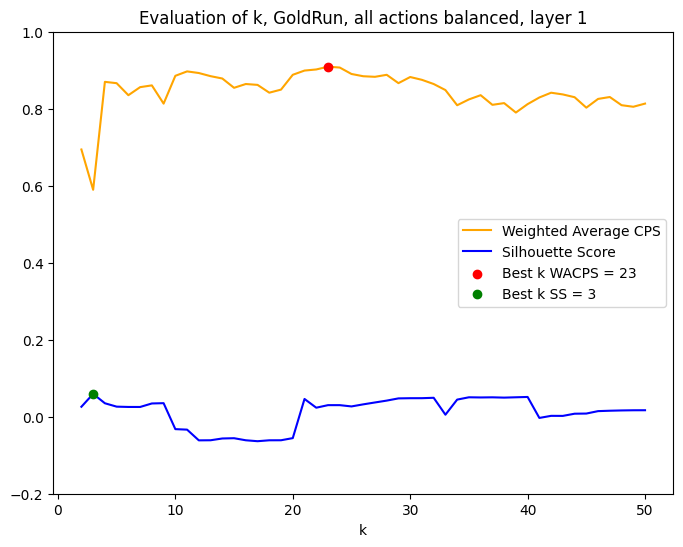

3


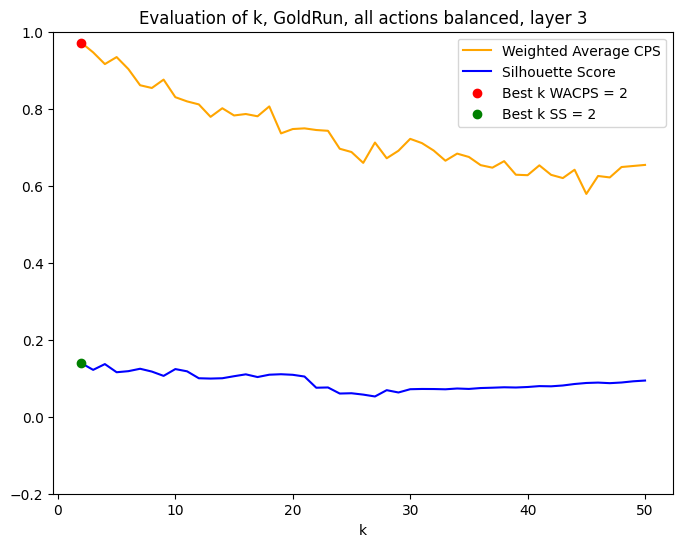

4


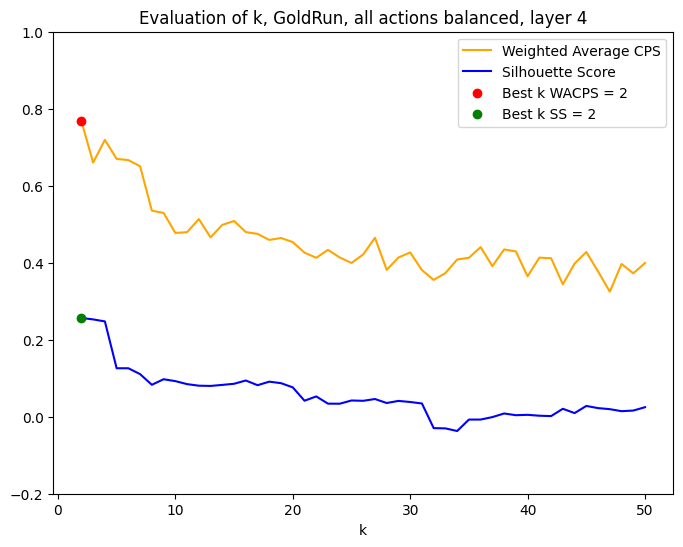

5


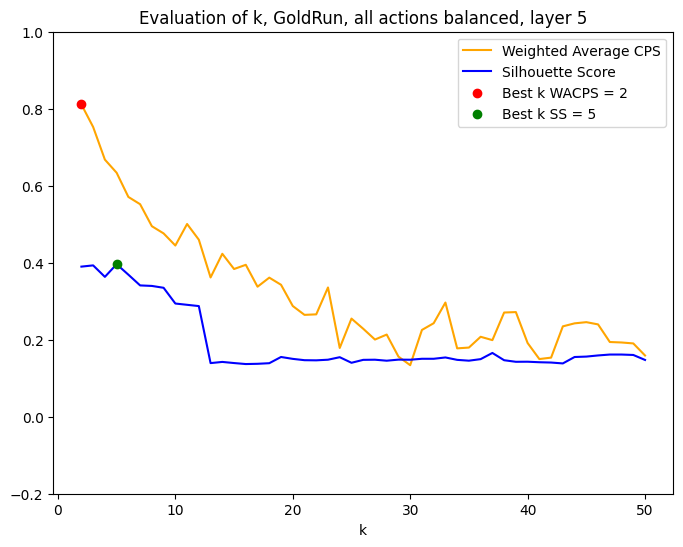



action up, evaluation of k:

0


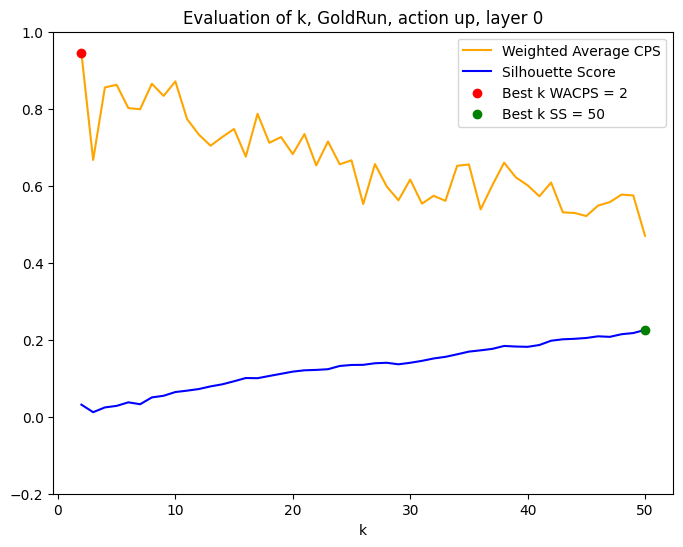

1


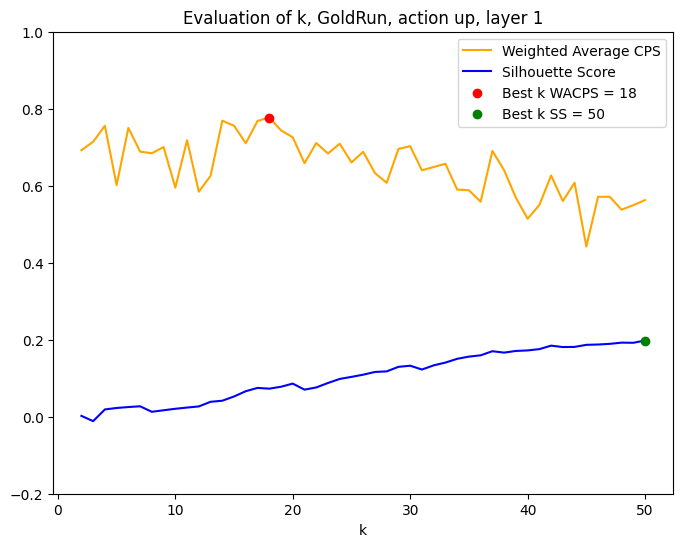

3


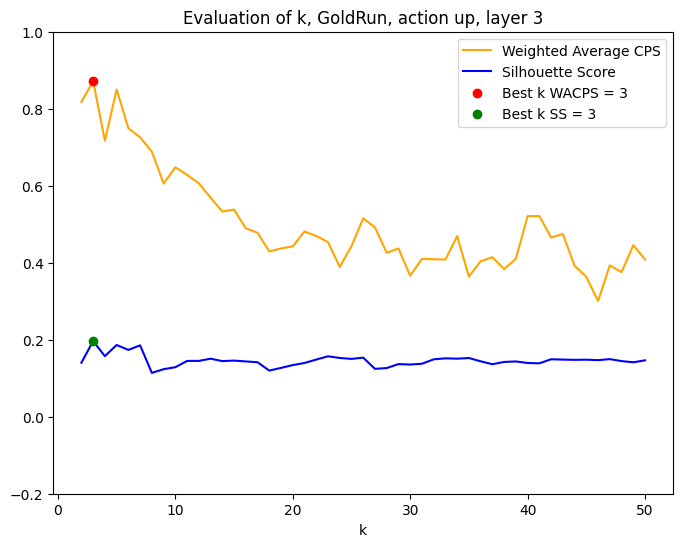

4


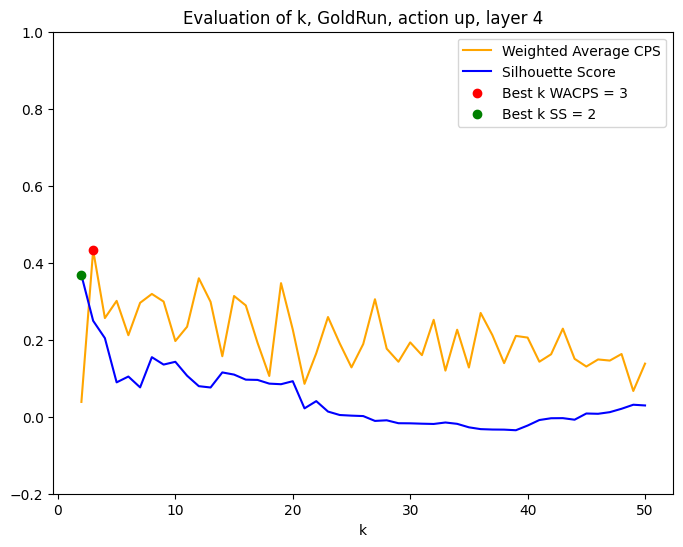

5


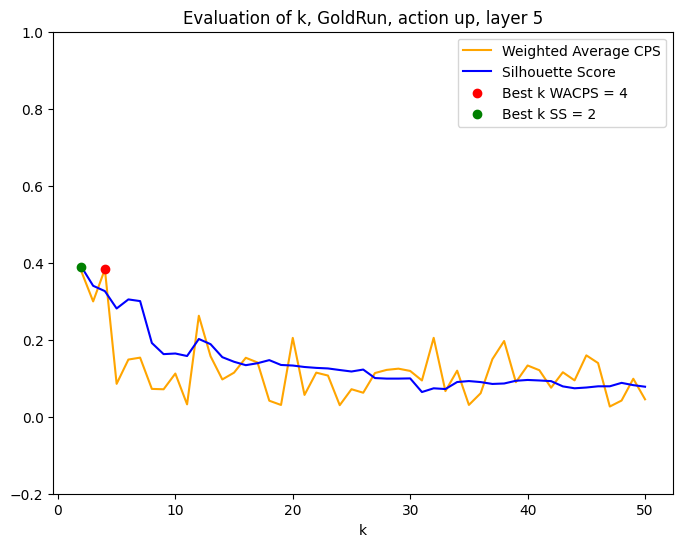



action right, evaluation of k:

0


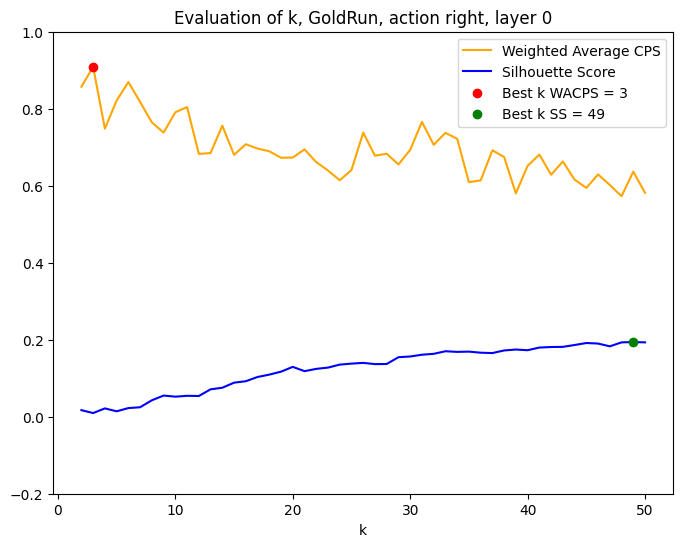

1


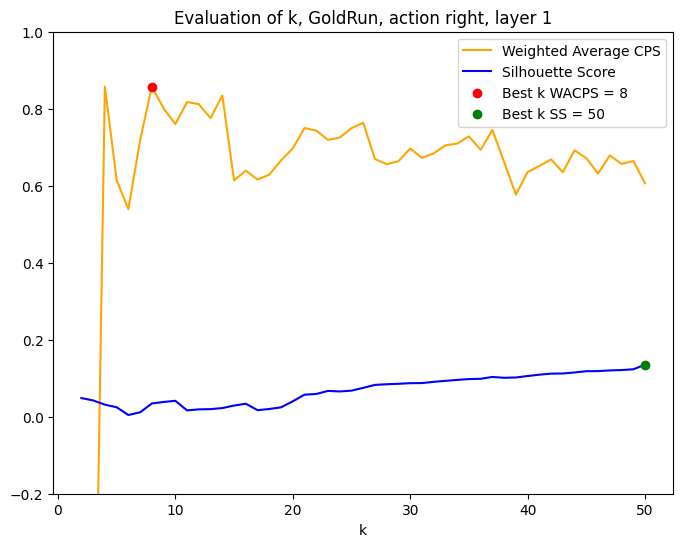

3


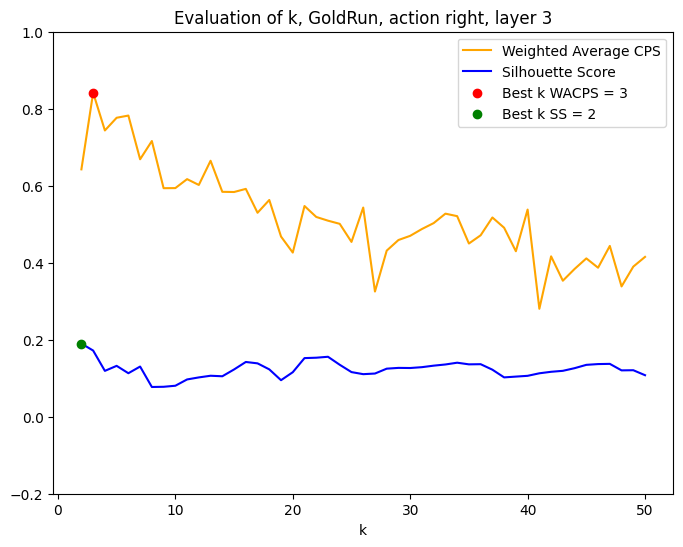

4


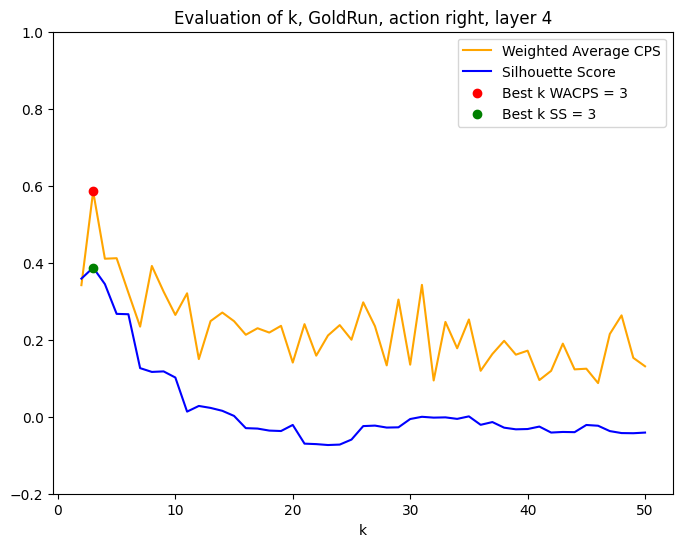

5


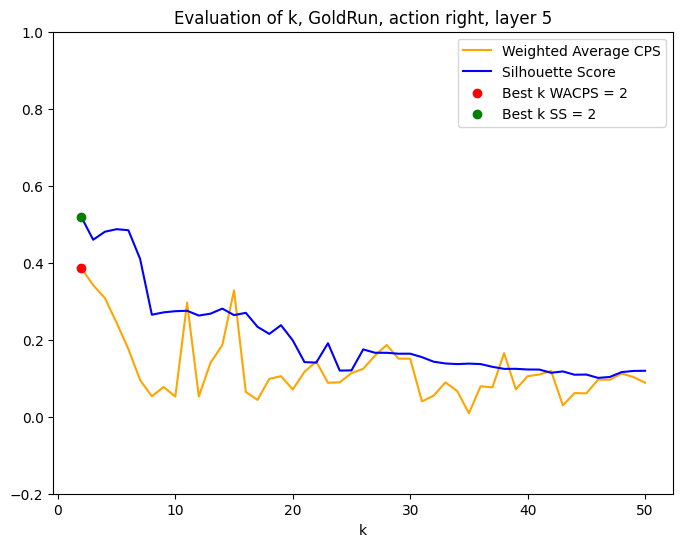



action down, evaluation of k:

0


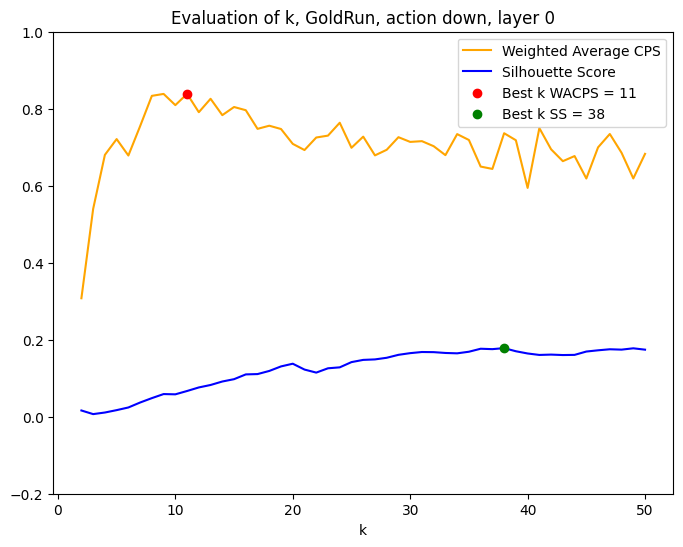

1


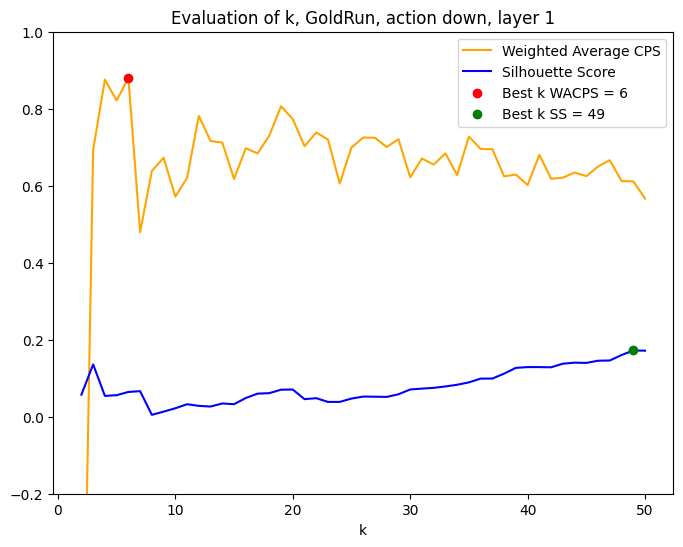

3


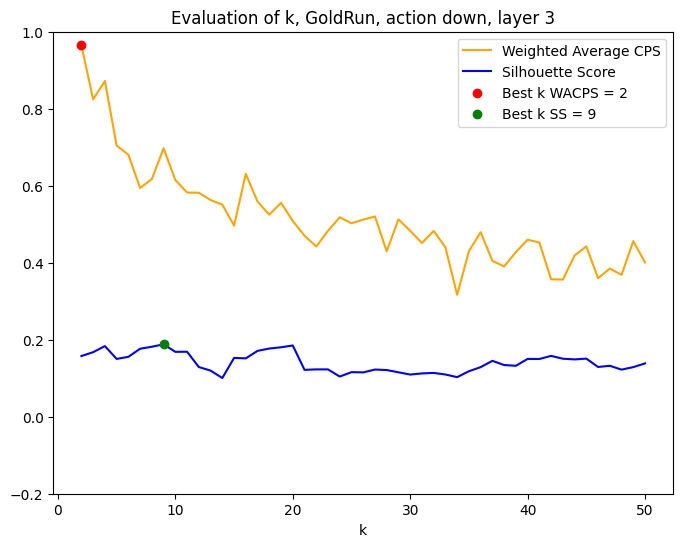

4


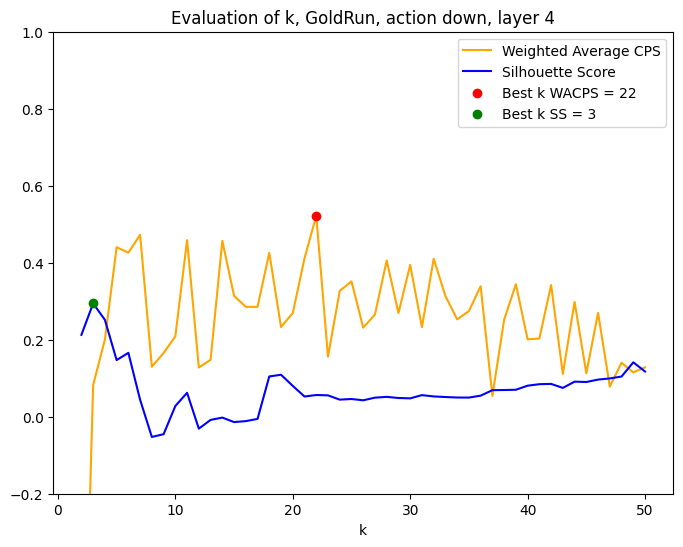

5


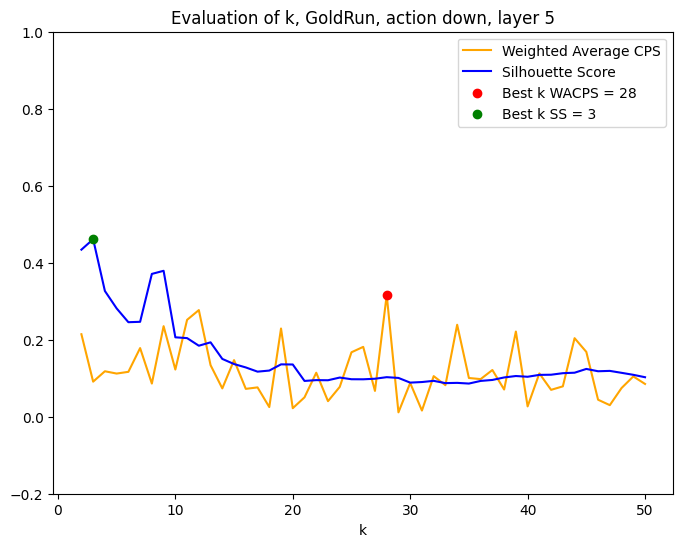



action left, evaluation of k:

0


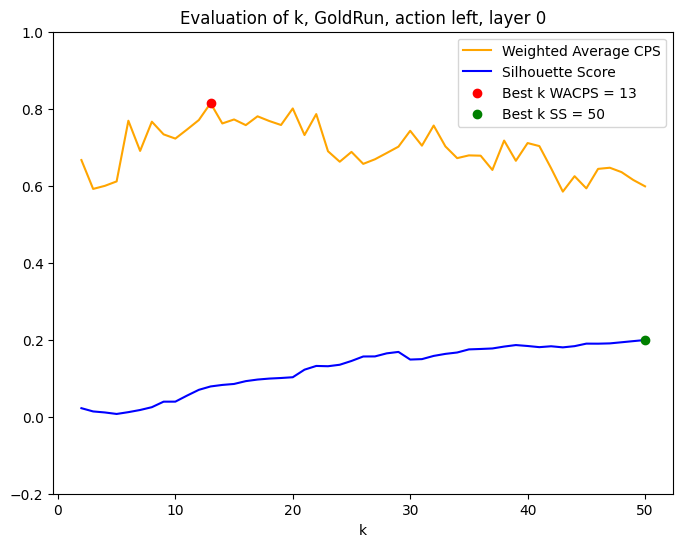

1


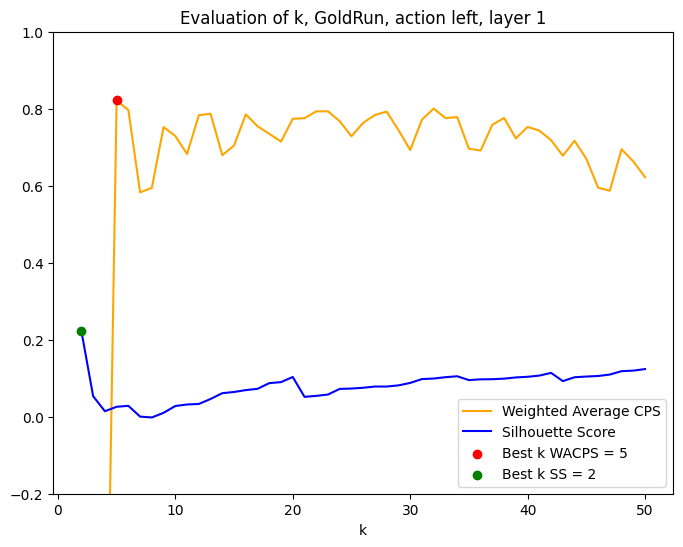

3


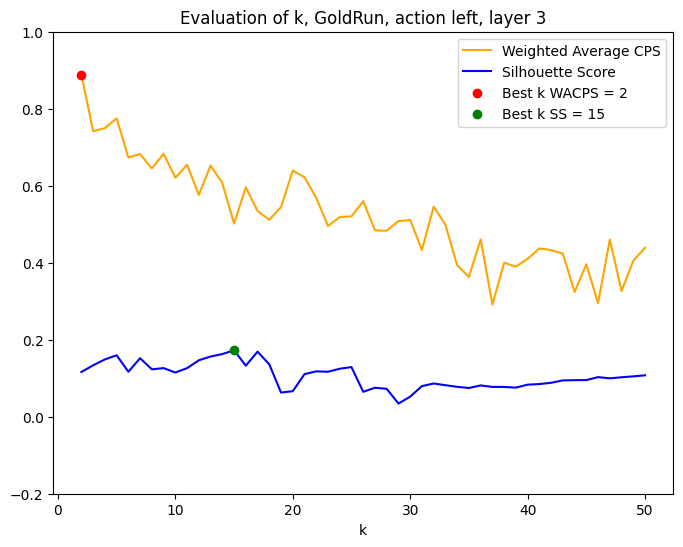

4


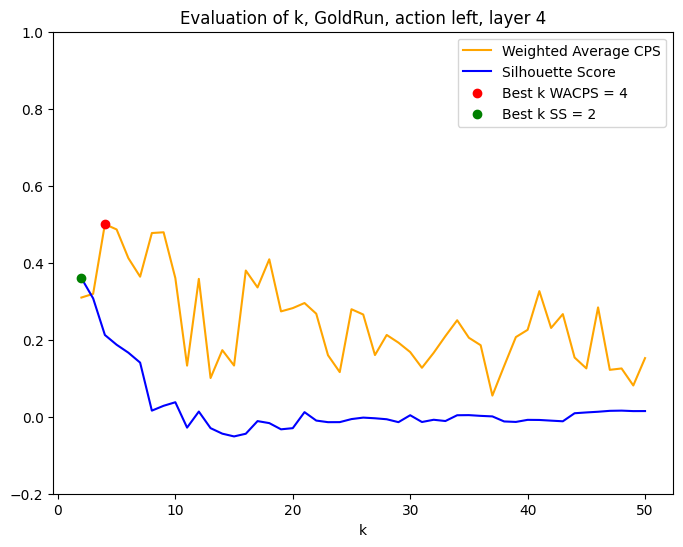

5


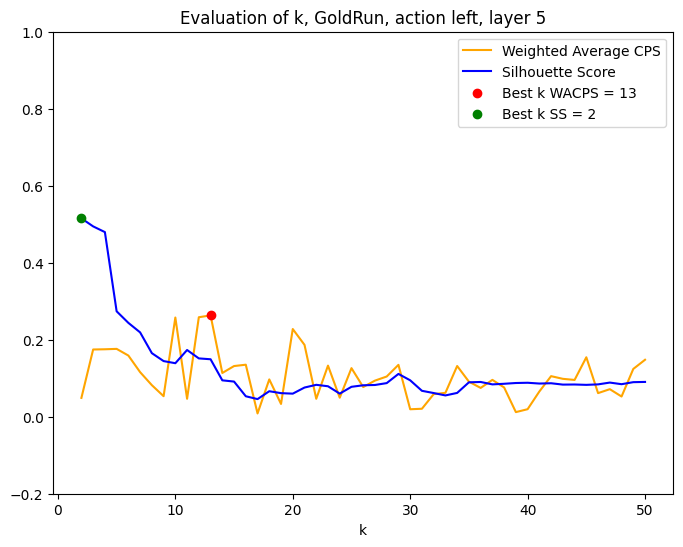


Average distance between best k (CPS vs SS) per layer:

   layer  avg_k_distance
0      0            40.8
1      1            28.0
2      3             4.2
3      4             4.4
4      5             8.2

Top weighted average CPS scores per layer:

       all actions balanced  action up  action right  action down  action left
layer                                                                         
0                  0.960331   0.944751      0.908721     0.838574     0.814392
1                  0.909134   0.777065      0.857412     0.880522     0.821976
3                  0.971376   0.871333      0.841617     0.964809     0.888393
4                  0.767666   0.432644      0.585246     0.522181     0.500120
5                  0.811111   0.383001      0.385542     0.316121     0.263211

Average best k per layer (CPS vs SS):

       avg_best_k_cps  avg_best_k_ss
layer                               
0                 6.4           47.2
1                12.0           30.8
3      

In [157]:
gr_agreement_df = plot_cluster_evaluations(dfs=gr_dfs, class_names=gr_class_names, enviornment_name="GoldRun")
results = compute_stats(gr_agreement_df, gr_dfs, gr_class_names)

### MinecartCounter

In [ ]:
mc_down_k_scores = pd.read_csv("../../rl_ace_data/concept_examples/minecart_counter/k_means/model_of_interest_target_class_down_observations/dim_reduction/k_evaluation.csv")
mc_downleft_k_scores = pd.read_csv("../../rl_ace_data/concept_examples/minecart_counter/k_means/model_of_interest_target_class_downleft_observations/dim_reduction/k_evaluation.csv")
mc_downright_k_scores = pd.read_csv("../../rl_ace_data/concept_examples/minecart_counter/k_means/model_of_interest_target_class_downright_observations/dim_reduction/k_evaluation.csv")
mc_left_k_scores = pd.read_csv("../../rl_ace_data/concept_examples/minecart_counter/k_means/model_of_interest_target_class_left_observations/dim_reduction/k_evaluation.csv")
mc_up_k_scores = pd.read_csv("../../rl_ace_data/concept_examples/minecart_counter/k_means/model_of_interest_target_class_up_observations/dim_reduction/k_evaluation.csv")

# NOT DONE
mc_dfs = [mc_down_k_scores, mc_downleft_k_scores, mc_downright_k_scores, mc_left_k_scores, mc_up_k_scores]
mc_class_names = ["action down", "action downleft", "action downright", "action left", "action up"]



action down, evaluation of k:

0


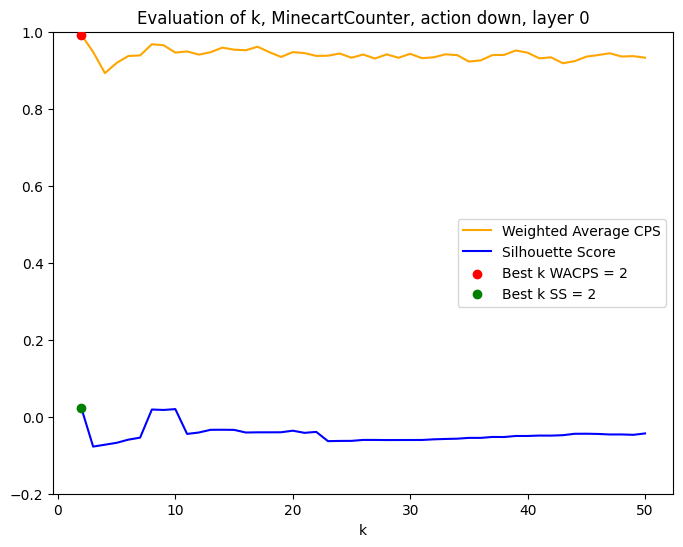

1


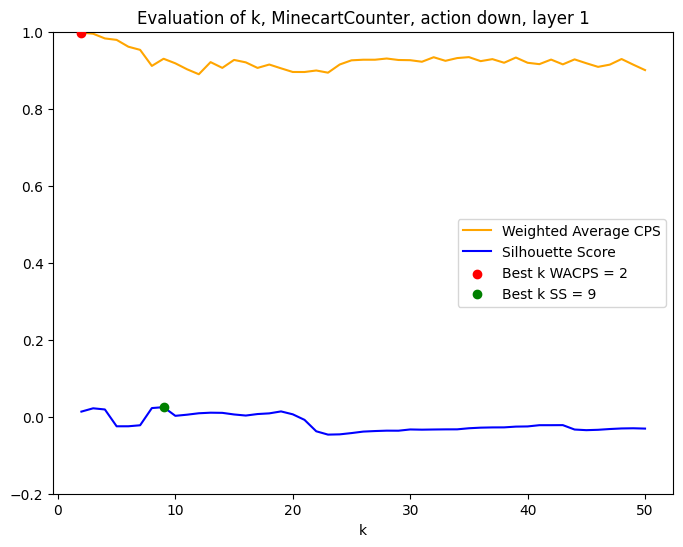

3


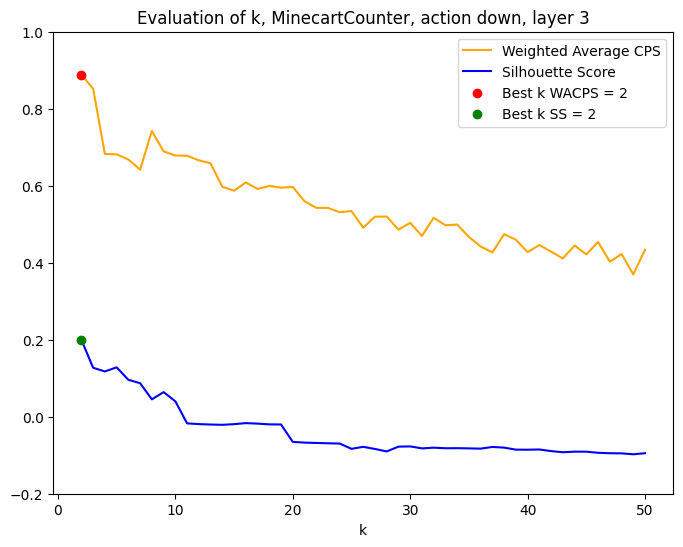

4


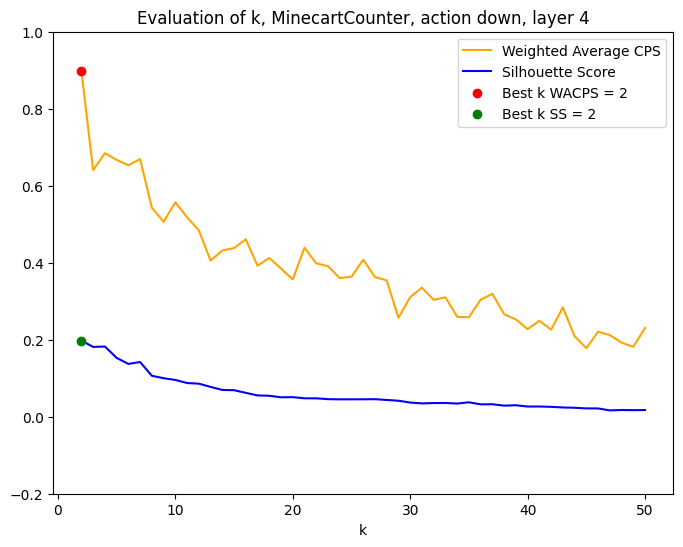

5


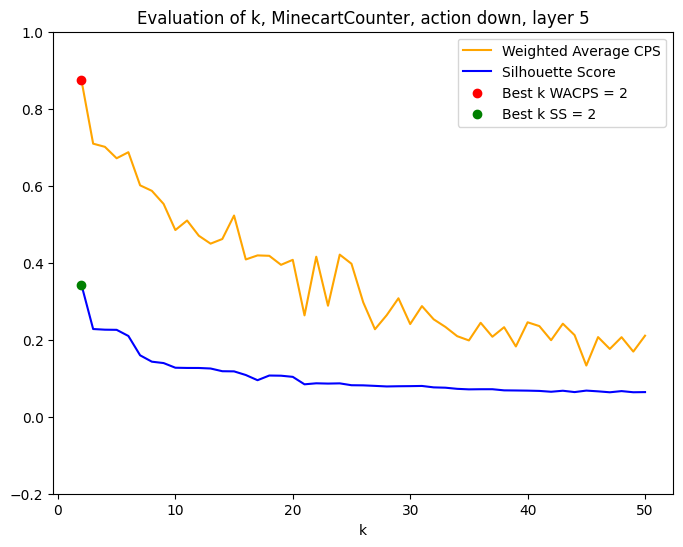



action downleft, evaluation of k:

0


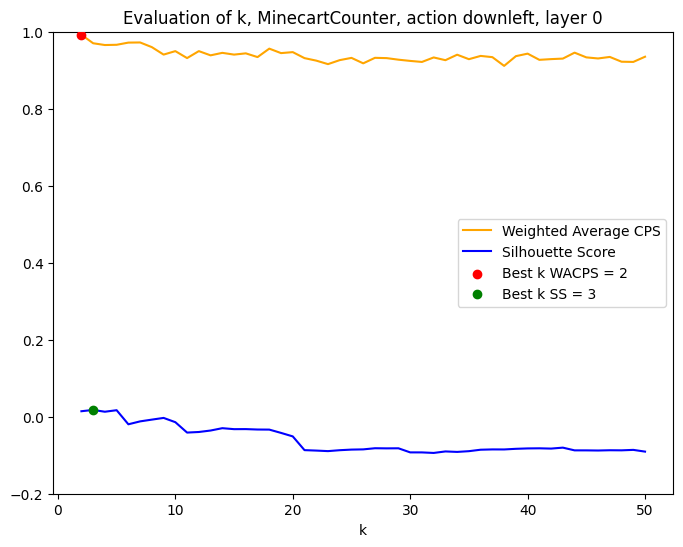

1


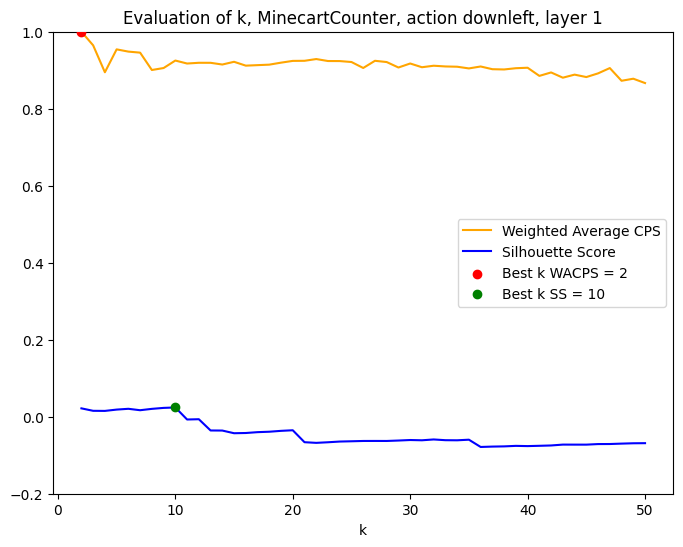

3


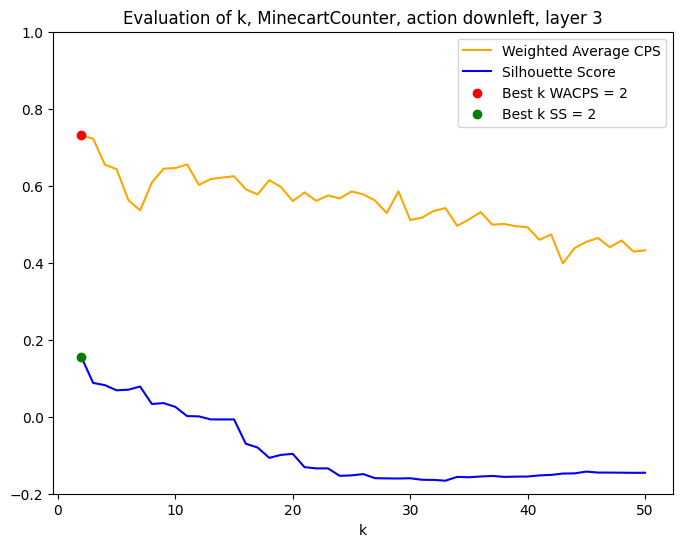

4


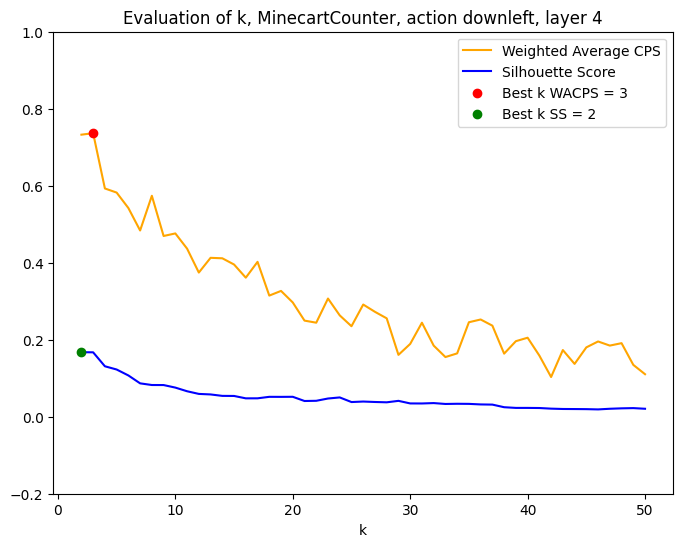

5


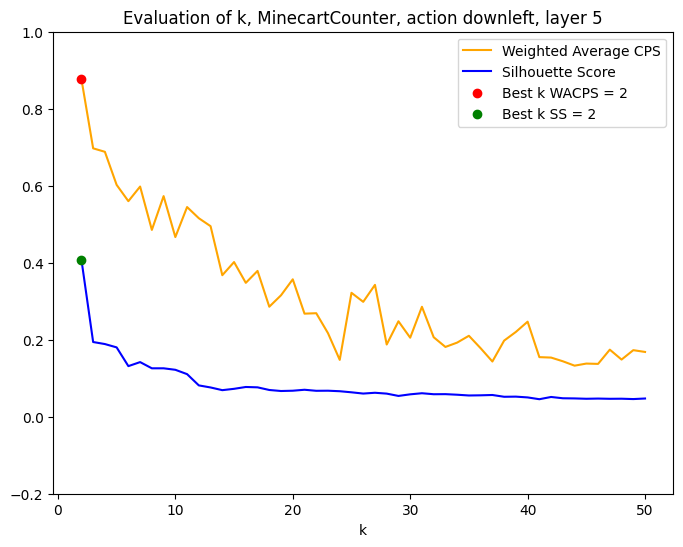



action downright, evaluation of k:

0


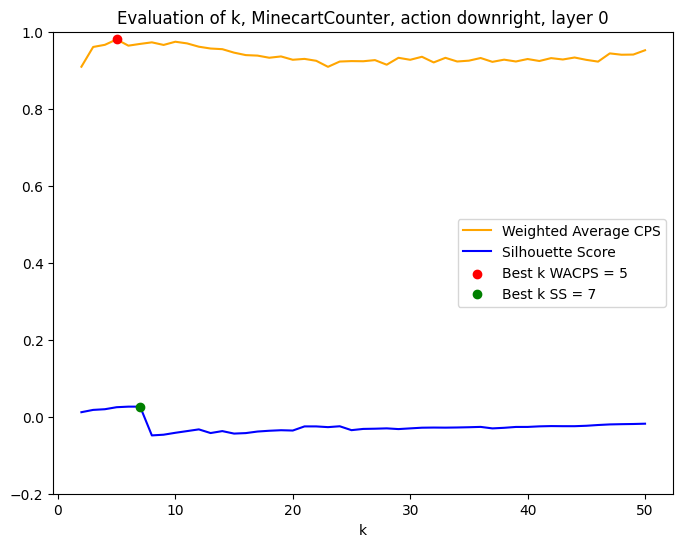

1


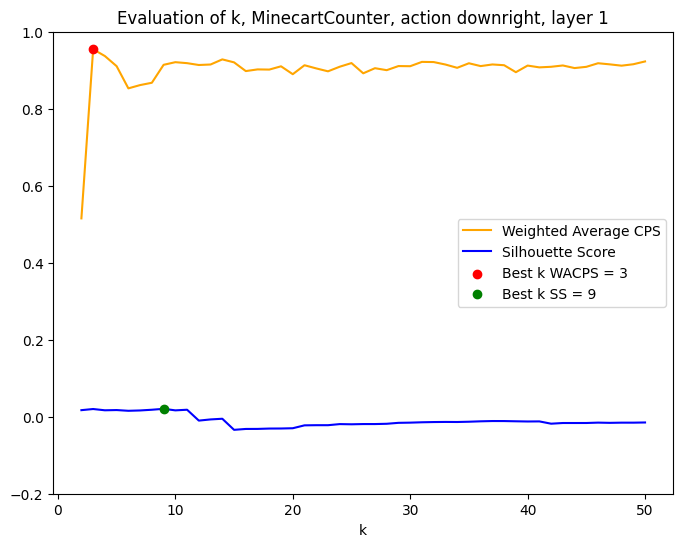

3


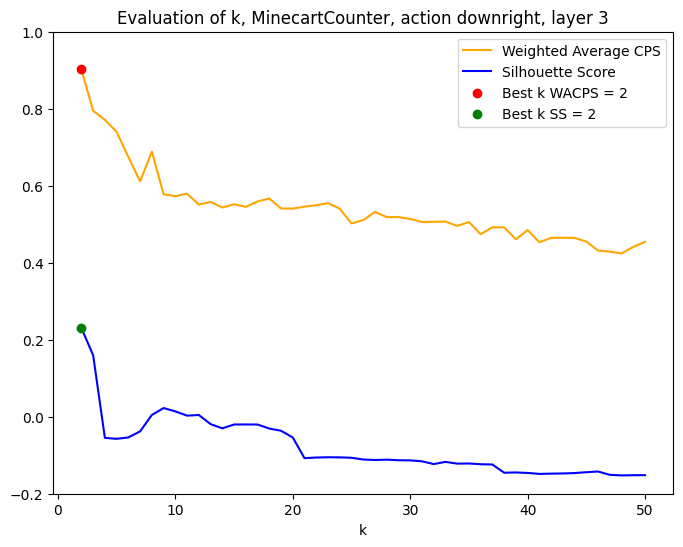

4


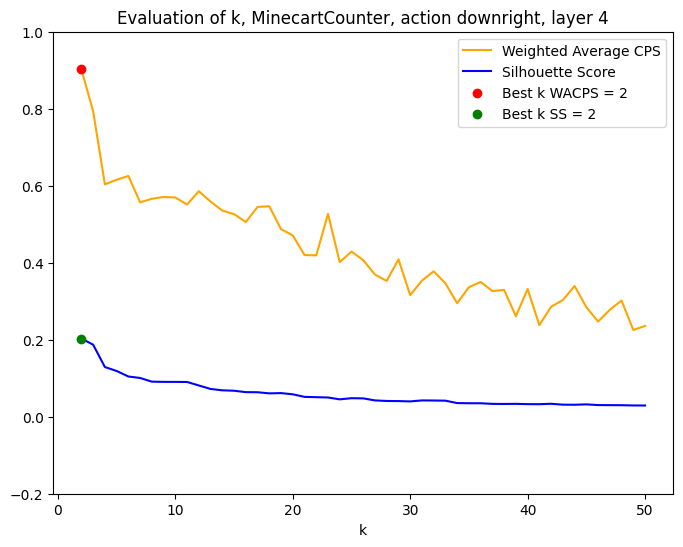

5


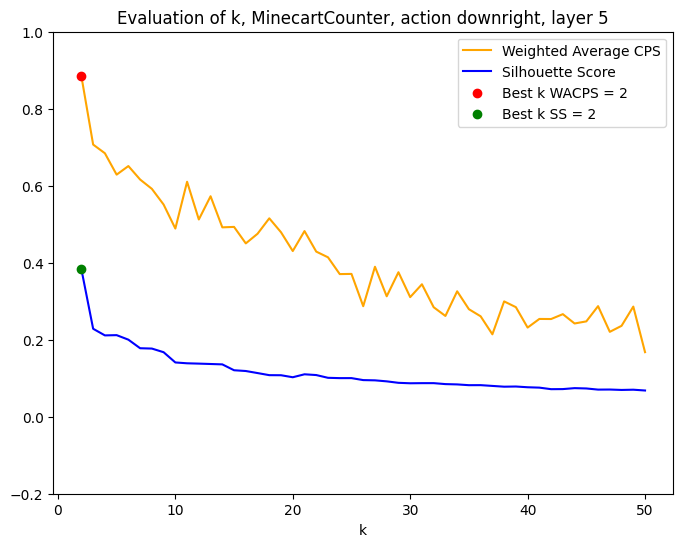



action left, evaluation of k:

0


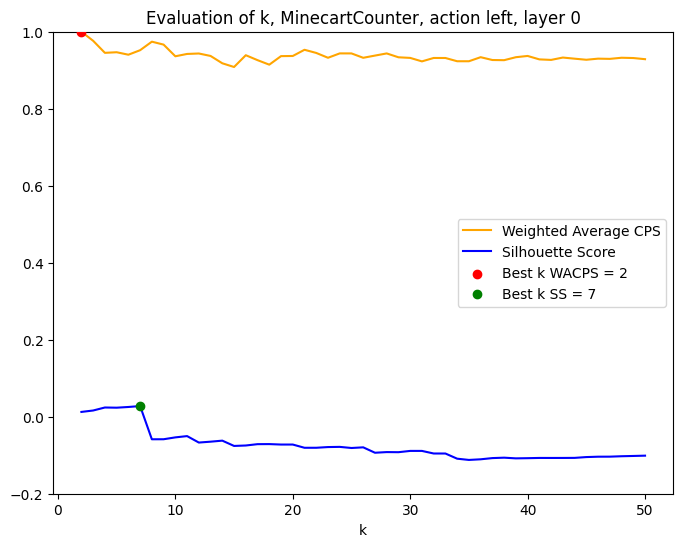

1


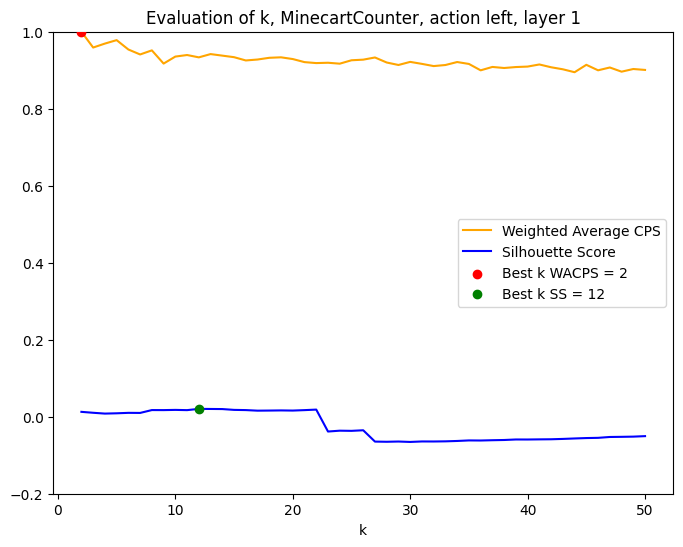

3


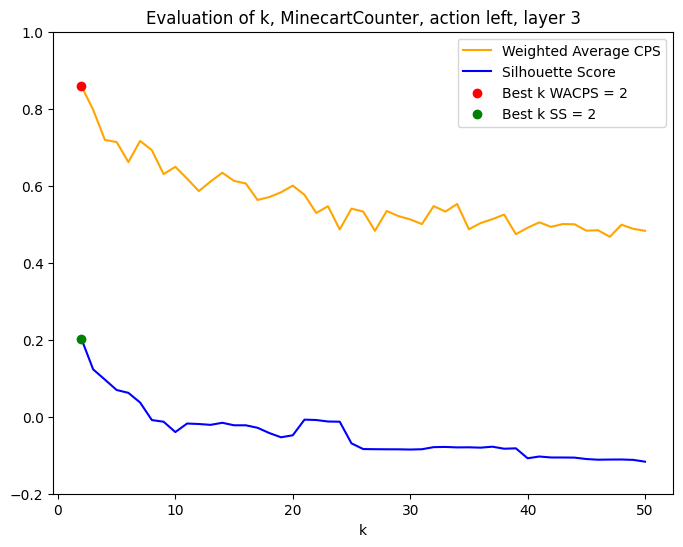

4


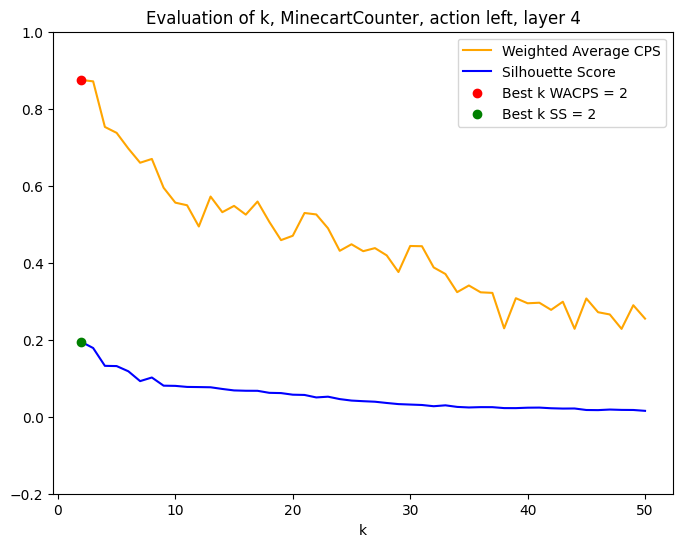

5


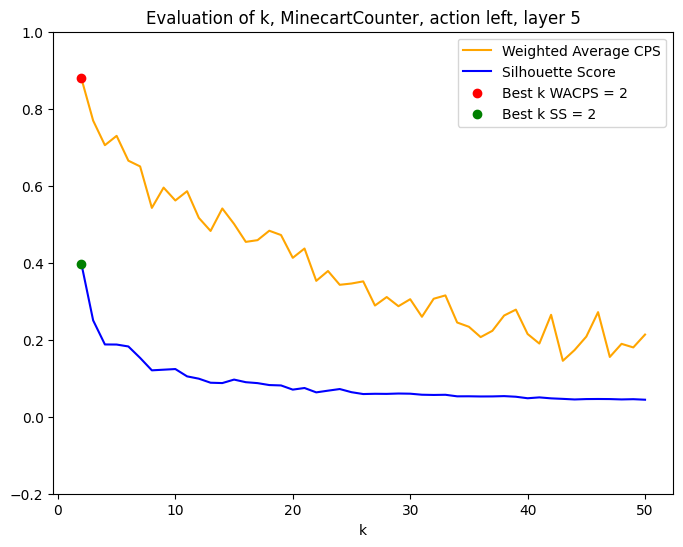



action up, evaluation of k:

0


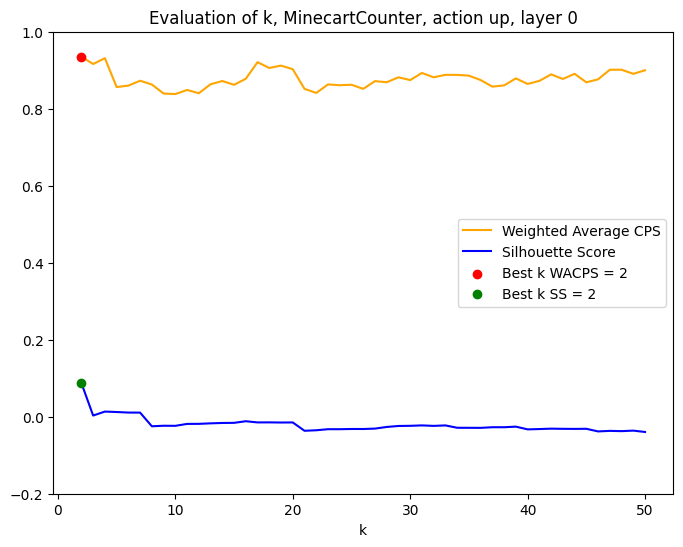

1


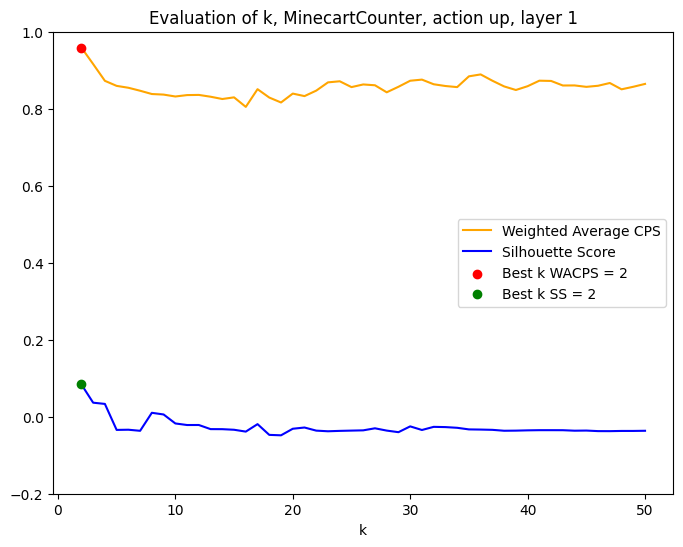

3


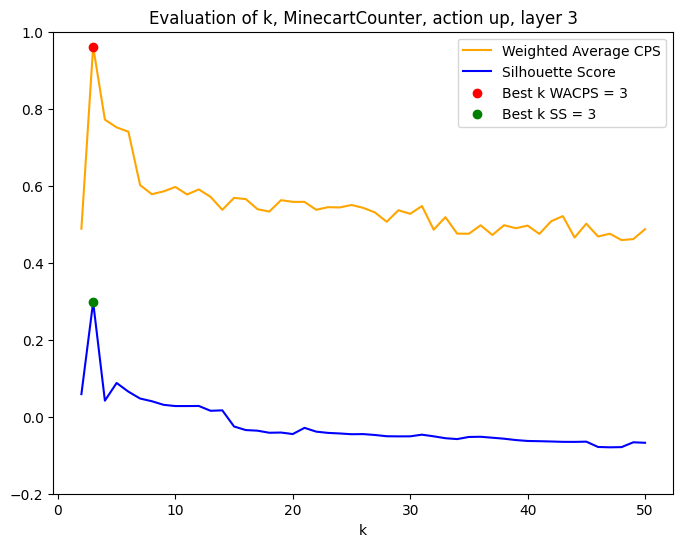

4


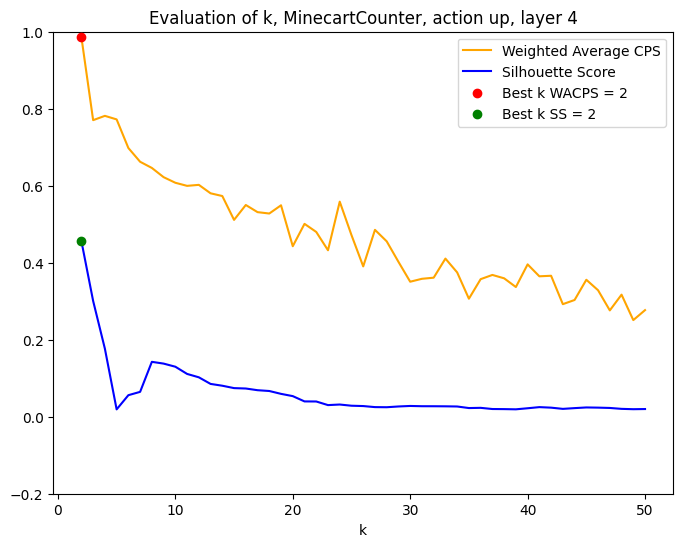

5


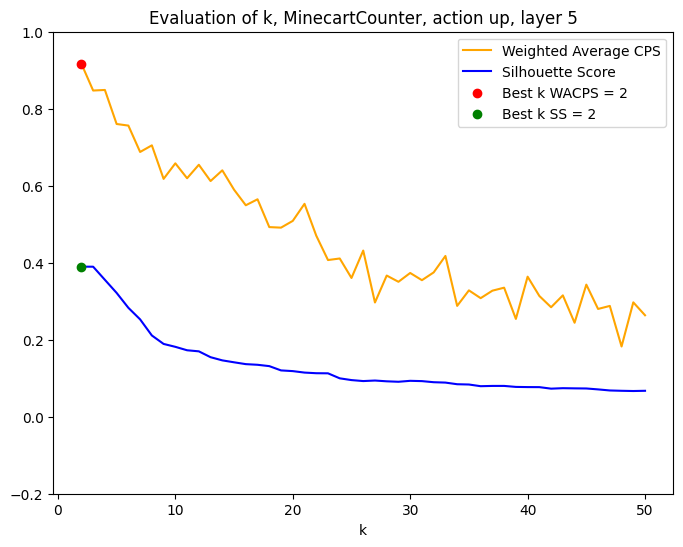


Average distance between best k (CPS vs SS) per layer:

   layer  avg_k_distance
0      0             1.6
1      1             6.2
2      3             0.0
3      4             0.2
4      5             0.0

Top weighted average CPS scores per layer:

       action down  action downleft  action downright  action left  action up
layer                                                                        
0         0.991628         0.992157          0.980009     1.000000   0.935121
1         0.997677         1.000000          0.954479     1.000000   0.958805
3         0.888350         0.730491          0.901981     0.858793   0.961381
4         0.898496         0.736435          0.902034     0.874639   0.985827
5         0.874598         0.877104          0.884141     0.878613   0.916844

Average best k per layer (CPS vs SS):

       avg_best_k_cps  avg_best_k_ss
layer                               
0                 2.6            4.2
1                 2.2            8.4
3             

In [159]:
mc_amceement_df = plot_cluster_evaluations(dfs=mc_dfs, class_names=mc_class_names, enviornment_name="MinecartCounter")
results = compute_stats(mc_amceement_df, mc_dfs, mc_class_names)